In [ ]:
!gdown --id 1CACpD4cXHJCHDUlyS0Yih-ScP568eJvi

Downloading...
From: https://drive.google.com/uc?id=1CACpD4cXHJCHDUlyS0Yih-ScP568eJvi
To: /content/iyer.txt
100% 33.5k/33.5k [00:00<00:00, 27.5MB/s]


In [ ]:
!gdown --id 1hq9Q9B6fvUPyazzrdnnqSy5JO7sAuUg4

Downloading...
From: https://drive.google.com/uc?id=1hq9Q9B6fvUPyazzrdnnqSy5JO7sAuUg4
To: /content/cho.txt
100% 36.3k/36.3k [00:00<00:00, 58.1MB/s]


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from numpy import linalg
import math
from sklearn.cluster import KMeans, SpectralClustering # I have it here to verify my results .. 
from sklearn import metrics


In [ ]:
#read the dataset as numpy
#data = np.loadtxt(open('cho.txt',newline=''), delimiter='\t')
data = np.loadtxt(open('iyer.txt',newline=''), delimiter='\t')
data.shape

(517, 14)

In [ ]:
import pandas as pd

pd.DataFrame(data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,517.000000,517.000000,517.0,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,259.000000,3.661509,1.0,1.005532,1.125938,1.274468,1.209400,1.455048,1.553056,1.476383,1.263598,1.317756,1.366673,1.465242
std,149.389312,3.091550,0.0,0.318470,0.759588,1.242392,0.987092,2.391082,4.206261,2.285663,1.550076,1.311602,1.309554,1.499022
min,1.000000,-1.000000,1.0,0.310000,0.100000,0.320000,0.310000,0.170000,0.160000,0.100000,0.130000,0.160000,0.130000,0.120000
25%,130.000000,1.000000,1.0,0.830000,0.760000,0.780000,0.790000,0.620000,0.500000,0.440000,0.440000,0.670000,0.650000,0.670000
50%,259.000000,2.000000,1.0,0.970000,0.950000,0.970000,0.970000,0.850000,0.740000,0.660000,0.650000,0.920000,0.920000,0.950000
75%,388.000000,6.000000,1.0,1.120000,1.220000,1.210000,1.160000,1.490000,1.650000,1.870000,1.670000,1.620000,1.620000,1.590000
max,517.000000,10.000000,1.0,3.350000,8.140000,12.690000,11.480000,38.800000,86.920000,25.580000,14.810000,15.210000,13.750000,11.020000


In [ ]:
#see the numbers of outlier in each data set:
(np.argwhere(data[:,1] == -1)).shape


(33, 1)

Text(0.5, 1.0, 'PCA of Iyer dataset')

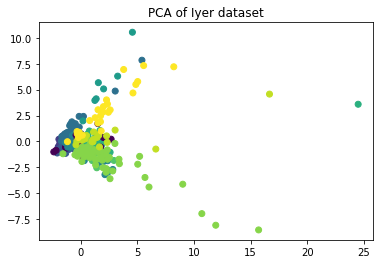

In [ ]:
#visualize the data
#normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[:,2:])

#PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.scatter(x = pca_data[:, 0], y = pca_data[:,1], c=data[:,1])
plt.title('PCA of Iyer dataset')


In [ ]:
#Kmeans clustering 
def Kmeans(data, K, eps = 0.001):
  #
  centers = np.zeros((K, len(data[0])))
  previous_centers = centers
  #choose random centers
  rand_indx = np.random.permutation(len(data))
  centers = data[rand_indx[0:K], :]

  #set the cluster labels as zeros first
  clusters = np.zeros((len(data)))
  center_changes=1
  while(center_changes >= eps):
    center_changes = 0
    for i in range(len(data)):
      dis = distance(data[i, :], centers)
      clusters[i] = np.argmin(dis)
    # I had to do deep copy here .. 
    previous_centers[:, :] = centers[:, :]

    #updating the clusters:
    for i in range(0, K):
      temp = data[np.argwhere(clusters==i),:]
      centers[i, :] = np.mean(temp, axis=0)
    #check if the centers changed noticably
    for i in range(0, K):
      center_changes += np.sqrt(sum(np.power(previous_centers[i, :]- centers[i, :], 2)))
    
  return(clusters,centers)



In [ ]:
def distance(data, centers):
  dis = [0]*len(centers)
  for i in range(len(centers)):
    dis[i] = np.sqrt(sum(np.power((data-centers[i]), 2)))
  return dis


In [ ]:
# K=4
# clusters, centers = Kmeans(data[:, 2:], K, eps = 0.0001)
#visualize the data
#PCA
def visualize(data, cluster, title):
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(data)
  plt.scatter(x =pca_data[:, 0], y = pca_data[:,1], c=clusters)
  plt.title(title)

In [ ]:
# external index --  I used entropy, purity and normalized mutual information as the external index 
def external_index(clusters, labels):
  entropy = 0
  total_purity = 0
  unique_labels = list(set(labels))
  # I analyzed the data once without outliers once with the outliers to see what happens
  if -1 in unique_labels:
    unique_labels.remove(-1) # we need to remove the outliers
  
  unique_clusters = list(set(clusters))

  for clstr in unique_clusters:
    entropy_i = 0
    purity_i =0
    purity_max = 0
    for l in unique_labels:
      Ci = [x for x in range(len(labels)) if labels[x]==l] # all the samples with class c
      Di = [x for x in range(len(clusters)) if clusters[x] == clstr] # samples within clstr cluster 

      P_i_j = len([x for x in Ci if x in Di])/len(Di) # 
      if P_i_j!=0:
        entropy_i += P_i_j*math.log2(P_i_j)
        # entropy_i = -1*entropy_i
        purity_i = max(P_i_j,purity_i)
    entropy += (len(Di)/len(clusters))*(entropy_i)
    total_purity += ((len(Di)/len(clusters))*(purity_i))
  entropy = (-1*entropy) #I need to ask whether I need to report it as a negative or positive value -- there is negative in the formula but it is mentioned it is a negative measure! Got it: it is a negative measure in a sense that the lower the value the better our results
  return entropy, total_purity





In [ ]:
#internal index -- Sihousetee Coefficient
def internal_index(data, clusters, labels):
  sht = [0]*len(data)
  unique_clusters = list(set(clusters))
  a_i = 0
  for i in range(len(data)):
    clstr = int(clusters[i])
    if (len(clusters[clusters==clstr])-1)!=0:
      a_i = sum(distance(data[i, :], data[clusters==clstr, :]))/(len(clusters[clusters==clstr])-1)
    
    #b = [0]*len(unique_clusters)
    b = []
    for j in range(len(unique_clusters)):
      if int(unique_clusters[j] == clstr):
        continue
      b.append(sum(distance(data[i, :],data[clusters==unique_clusters[j],: ]))/len(clusters[clusters==unique_clusters[j]]))
    if len(b)>0:
      # print('what is B: ', b)
      b = min(b)
    if max(a_i,b)!=0:
      sht[i] = (b-a_i)/max(a_i,b)
    if np.isnan(sht[i]):
      print(max(a_i,b))
  SHT = np.mean(sht)
  # if np.isnan(SHT):
  #   print('check this: ',(b-a_i), max(a_i,b), sht)
  return SHT

In [ ]:
#spectral clustering
def spectral(data, K, sigma):
  #W : the simialrity matrix
  W = np.zeros((len(data), len(data)))
  #D: Degree matrix
  D = np.zeros((len(data), len(data)))

  for i in range(len(data)):
    temp= np.exp((-1*(np.asarray(distance(data[i,:], data))))/2*sigma**2)
    # only choose the K-nearset neughbors (based on slide 58), and the rest will be zeros
    temp[temp<(sorted(temp)[len(temp)-K])] = 0 
    W[i, :] = temp
    D[i, i] = sum(temp) #sum of each row in the W matrix 
  L = D - W
  
  #get the eigne values and the eigen vectors
  eig_vector, eig_value = linalg.eig(L)
  # print('these are the eig_vector: ', eig_vector) -> So, eigen vectors are complex numbers!!
  #choose the K as the one that maximizes the difference between two sequential eignen vectors .. 
  #choosen_k = np.argmax(((np.sort_complex(eig_vector)[1:]) - (np.sort_complex(eig_vector)[0:-1]))) 
  #print('Chosen K: {0} , len of data {1}'.format(choosen_k,len(data)))
  choosen_k = len(data) -  np.argmax(np.sort_complex(eig_vector)[1:] - np.sort_complex(eig_vector)[0:-1]) #sort complex sort them in assending order but we need the descending order 
  # print('Chosen K: ', np.argmax(np.sort_complex(eig_vector)[1:] - np.sort_complex(eig_vector)[0:-1]) )
  print(len(data))

  indx = np.argsort(eig_vector)[-K:]
  egin_data = eig_value[:, indx]

  clusters, centers = Kmeans(egin_data, choosen_k)
  return clusters, centers

In [ ]:
def best_matching(k_labels, truth):
  k_labels_matched = np.empty_like(k_labels)
  # For each cluster label...
  for k in np.unique(k_labels):

      # ...find and assign the best-matching truth label
      match_nums = [np.sum((k_labels==k)*(truth==t)) for t in np.unique(truth)]
      k_labels_matched[k_labels==k] = np.unique(truth)[np.argmax(match_nums)]
  return k_labels_matched

In [ ]:
#FOR VALIDATION:
# I only added this to validate my purity calculation. this is done using contingency matrix and is similar to formula given in slide 51 of lecture 8 
from sklearn.metrics import confusion_matrix
def purity_score(truth, y_pred):
    cm = confusion_matrix(truth, y_pred)
    # return purity
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm) 

 ---- K-means results ----
External indexs:
Entropy:  2.431686952193754
purity:  0.38878143133462284
Sihousetee (internal_index):  0.3479167733891473
Validating purity using confusion matrix:  0.38878143133462284


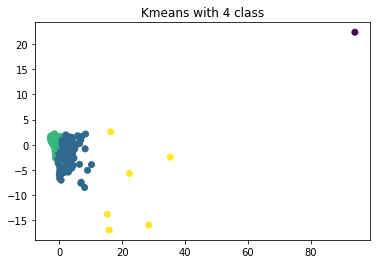

In [ ]:
# ************* << K-means resuls >> *************
K = 4
clusters, centers = Kmeans(data[:, 2:], K)
k_labels_matched = best_matching(clusters, data[:, 1])
visualize(data[:, 2:], k_labels_matched, 'Kmeans with 4 class')
entropy, purity = external_index(k_labels_matched, data[:, 1])
SHT = internal_index(data, k_labels_matched, data[:, 1])
print(' ---- K-means results ----')
print('External indexs:')
print('Entropy: ',entropy)
print('purity: ',purity)
print('Sihousetee (internal_index): ', SHT)

print('Validating purity using confusion matrix: ', purity_score(data[:, 1], k_labels_matched) )



517
(517,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


 ---- Spectral results ----
External indexs:
Entropy:  2.9570708559703176
purity:  0.30174081237911027
Sihousetee (internal_index):  -0.3834060618722651
Validating purity using confusion matrix:  0.30174081237911027


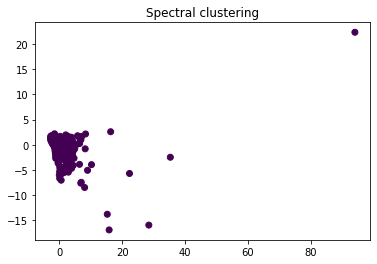

In [ ]:
# Spectral method
K = 4
sigma = 1
clusters, centers = spectral(data[:, 2:], K, sigma)
k_labels_matched = best_matching(clusters, data[:, 1])
k_labels_matched = clusters
visualize(data[:, 2:], k_labels_matched, 'Spectral clustering')
entropy, purity = external_index(k_labels_matched, data[:, 1])
print(k_labels_matched.shape)
SHT = internal_index(data[:, 2:], k_labels_matched, data[:, 1])
print(' ---- Spectral results ----')
print('External indexs:')
print('Entropy: ',entropy)
print('purity: ',purity)
print('Sihousetee (internal_index): ', SHT)
print('Validating purity using confusion matrix: ', purity_score(data[:, 1], k_labels_matched) )






 ---- K-means results ----
External indexs:
Entropy:  2.421095889359963
purity:  0.38878143133462284
Sihousetee (internal_index):  0.20696075278110834


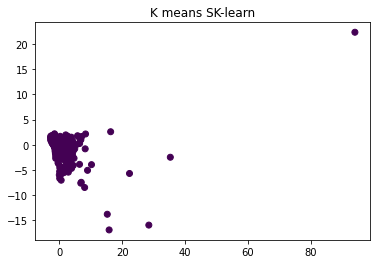

In [ ]:
#VALIDATION:
# Here I am only checking my result with Sklearn results:
clusters_sklearn = KMeans(n_clusters = 4).fit(data[:, 2:])

visualize(data[:, 2:], clusters_sklearn, 'K means SK-learn')
entropy, purity = external_index(clusters_sklearn.labels_, data[:, 1])
# print('shape of clustersss ', clusters_sklearn.labels_.shape)
# print('shape of labels ', data[:, 2].shape)
SHT = internal_index(data, clusters_sklearn.labels_, data[:, 1])
print(' ---- K-means results ----')
print('External indexs:')
print('Entropy: ',entropy)
print('purity: ',purity)
print('Sihousetee (internal_index): ', SHT)





/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


 ---- SpectralClustering results ----
External indexs:
Entropy:  3.013347814040009
purity:  0.28239845261121854
SHT  0.12983694039030713


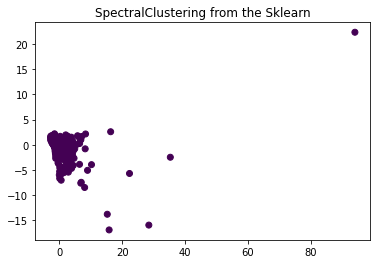

In [ ]:
# VALIDATION:
#checking my results with SpectralClustering from the Sklearn:
clusters_sklearn = SpectralClustering(n_clusters = 4).fit(data[:, 2:])
visualize(data[:, 2:], clusters_sklearn, 'SpectralClustering from the Sklearn')
entropy, purity = external_index(clusters_sklearn.labels_, data[:, 1])
SHT = internal_index(data, clusters_sklearn.labels_, data[:, 1])
print(' ---- SpectralClustering results ----')
print('External indexs:')
print('Entropy: ',entropy)
print('purity: ',purity)
print('SHT ', SHT)

In [ ]:
#analysing the two methods on different values of K
def exploring_k_effects(data):
  itr = 30
  results = np.zeros((itr, 4))
  for k in range(2,itr):
    # clusters, centers = Kmeans(data, K)
    # clusters, centers = spectral(data, K, 1)
    clusters, centers = Kmeans(data[:, 2:], k)
    k_labels_matched = best_matching(clusters, data[:, 1])

    entropy, purity = external_index(k_labels_matched, data[:, 1])
    SHT = internal_index(data, k_labels_matched, data[:, 1])
    results[k, 0] = k
    results[k, 1] = entropy
    results[k, 2]= purity
    results[k, 3] = SHT


  return results 

results = exploring_k_effects(data)




Text(0.5, 1.0, 'the effect of K value on entropy')

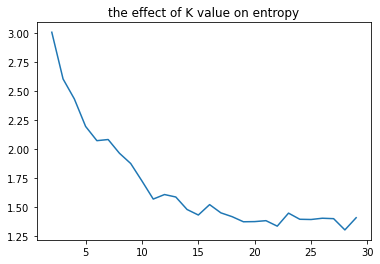

In [ ]:
#ploting
plt.plot(results[2:,0],results[2:,1])
plt.title('the effect of K value on entropy')

# plt.plot(results[2:,0],results[2:,2])
# plt.title('K effects on Purity')
# plt.show()

# plt.plot(results[2:,0],results[2:,3])
# plt.title('the effect of K value on Sihousetee Coefficient')